In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr

import metpy.constants

from sublimpy import tidy

from math import pi
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from windrose import WindroseAxes
import altair as alt
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

# User inputs

In [2]:
start_date = '20221130'
# end_date = '20230509'
end_date = '20230517'

start_date_lastseason = '20211101'
end_date_lastseason = '20220601'

tidy_dataset_fn = f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_dataset_5min_fn = f"../sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"
tidy_daily_dataset_output_fn = f"tidy_df_daily_{start_date}_{end_date}_noplanar_fit.parquet"

# Load data

## SoS

This dataset is created by the `create_turbulence_dataset.ipynb` notebook

In [3]:
try:
    tidy_df_30Min = pd.read_parquet(
        tidy_dataset_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_30Min['time'] = pd.to_datetime(tidy_df_30Min['time'])

try:
    tidy_df_5Min = pd.read_parquet(
        tidy_dataset_5min_fn
    )
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

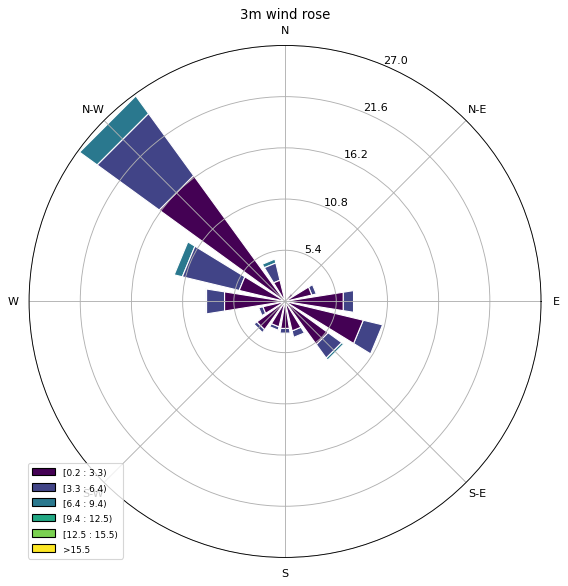

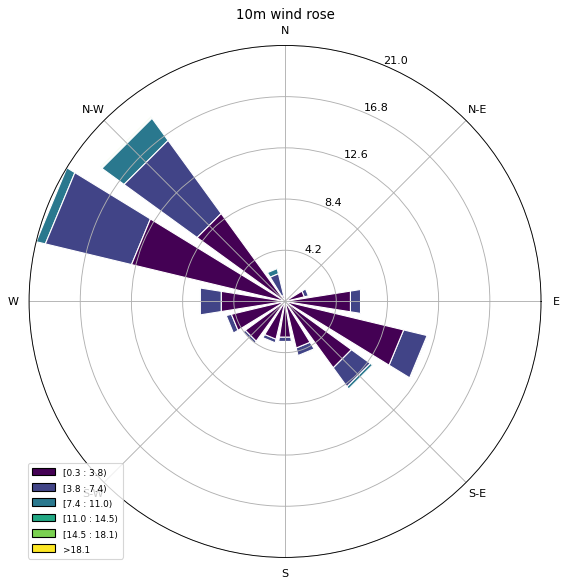

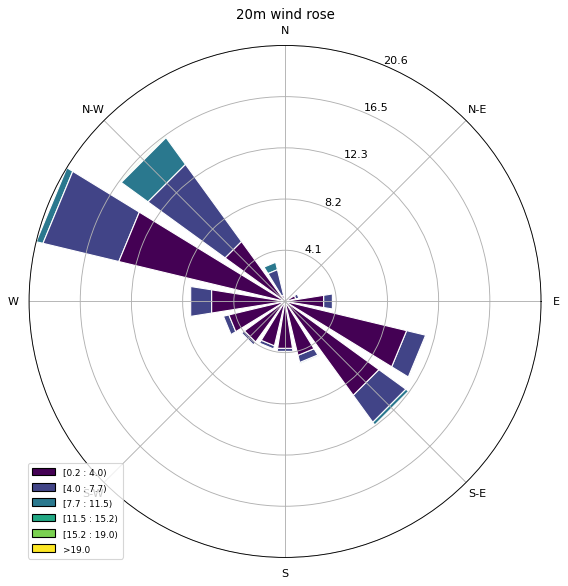

In [4]:
%matplotlib inline



src = tidy_df_30Min[
    tidy_df_30Min.variable.isin(['spd_3m_c', 'dir_3m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()


ax = WindroseAxes.from_ax()
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("3m wind rose")
plt.savefig("3m_wind_rose.png")

src = tidy_df_30Min[
    tidy_df_30Min.variable.isin(['spd_10m_c', 'dir_10m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()


ax = WindroseAxes.from_ax()
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("10m wind rose")
plt.savefig("10m_wind_rose.png")

src = tidy_df_30Min[
    tidy_df_30Min.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()


ax = WindroseAxes.from_ax()
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.title("20m wind rose")
plt.savefig("20m_wind_rose.png")

# Remove LH flux outliers

In [5]:
def get_outlier_threshold(values, iqr_multiple = 100):
    q1, q3 = np.percentile(sorted(values), [25, 75])

    # compute IRQ
    iqr = q3 - q1

    # find lower and upper bounds
    lower_bound = q1 - (iqr_multiple * iqr)
    upper_bound = q3 + (iqr_multiple * iqr)
    return lower_bound, upper_bound

In [6]:
measured_sublimation_variables = [ v for v in tidy_df_30Min.variable.unique() if v.startswith("w_h2o__") and 'predicted' not in v ]
measured_sublimation_variables

['w_h2o__10m_c',
 'w_h2o__10m_d',
 'w_h2o__10m_ue',
 'w_h2o__10m_uw',
 'w_h2o__15m_c',
 'w_h2o__1m_d',
 'w_h2o__1m_ue',
 'w_h2o__1m_uw',
 'w_h2o__20m_c',
 'w_h2o__2m_c',
 'w_h2o__3m_c',
 'w_h2o__3m_d',
 'w_h2o__3m_ue',
 'w_h2o__3m_uw',
 'w_h2o__5m_c']

In [7]:
for variable in measured_sublimation_variables:
    print(variable)
    filter = tidy_df_30Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_30Min.loc[filter, 'value'].dropna().values
    )
    print(f"Bounds, 30Min: {(lower_bound, upper_bound)}")
    is_included = (tidy_df_30Min.loc[filter, 'value'] > lower_bound) & (tidy_df_30Min.loc[filter, 'value'] < upper_bound)
    tidy_df_30Min.loc[filter, 'value'] = tidy_df_30Min.loc[filter, 'value'].where(is_included)
    print(f"{is_included.value_counts()[False]} dropped of {len(is_included)}")

    filter = tidy_df_5Min.variable == variable
    lower_bound, upper_bound = get_outlier_threshold(
        tidy_df_5Min.loc[filter, 'value'].dropna().values
    )
    print(f"Bounds, 5Min: {(lower_bound, upper_bound)}")
    is_included = (tidy_df_5Min.loc[filter, 'value'] > lower_bound) & (tidy_df_5Min.loc[filter, 'value'] < upper_bound)
    tidy_df_5Min.loc[filter, 'value'] = tidy_df_5Min.loc[filter, 'value'].where(is_included)
    print(f"{is_included.value_counts()[False]} dropped of {len(is_included)}")
    print()

w_h2o__10m_c
Bounds, 30Min: (-0.5149006102328713, 0.5197527067357441)
493 dropped of 8114
Bounds, 5Min: (-0.4790337040030863, 0.48330569348763674)
3339 dropped of 48672

w_h2o__10m_d
Bounds, 30Min: (-0.44800808974271905, 0.4522832808476475)
686 dropped of 8114
Bounds, 5Min: (-0.4329862864797178, 0.43695058904995676)
4595 dropped of 48672

w_h2o__10m_ue
Bounds, 30Min: (-0.4457888695199775, 0.44995280852132663)
688 dropped of 8114
Bounds, 5Min: (-0.4369024042971432, 0.4407225757604465)
4526 dropped of 48672

w_h2o__10m_uw
Bounds, 30Min: (-0.4966342744843738, 0.5014665804131557)
786 dropped of 8114
Bounds, 5Min: (-0.4722171462199185, 0.4765946025727317)
5273 dropped of 48672

w_h2o__15m_c
Bounds, 30Min: (-0.3604542065034195, 0.36388124285952017)
279 dropped of 8114
Bounds, 5Min: (-0.3394906352550606, 0.3424934405775275)
2058 dropped of 48672

w_h2o__1m_d
Bounds, 30Min: (-0.2722599976920416, 0.27452130151649123)
1770 dropped of 8114
Bounds, 5Min: (-0.27989095883094706, 0.28201769397128373)

# Calculate cumulative sublimation with daily mean latent heat fluxes

## Create daily dataset

In [8]:
tidy_df_30Min['date'] = tidy_df_30Min['time'].dt.date

tidy_df_daily = tidy_df_30Min.drop(columns=['time']).groupby(
    ['date', 'tower', 'height', 'measurement', 'variable']
).mean().reset_index()

tidy_df_daily['time'] = pd.to_datetime(tidy_df_daily['date'])

tidy_df_daily = tidy_df_daily.drop(columns=['date'])

# remove days with only partial data
tidy_df_daily = tidy_df_daily[
    tidy_df_daily.time > tidy_df_daily.time.min()
][
    tidy_df_daily.time < tidy_df_daily.time.max()
]

/tmp/ipykernel_135524/400594300.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df_daily = tidy_df_daily[


## Calculate cumulative sublimation

### For measured sublimation

In [9]:
seconds_per_day = 60*60*24
seconds_per_30min = 60*30
seconds_per_5min = 60*5
for variable in measured_sublimation_variables:
    height = int(variable.split('_')[-2].split('m')[0])
    tower = variable.split('_')[-1]
    tidy_df_daily = tidy.tidy_df_add_variable(
        tidy_df_daily,
        np.cumsum(tidy_df_daily.query(f"variable == '{variable}'")['value']*seconds_per_day).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        np.cumsum(tidy_df_30Min.query(f"variable == '{variable}'")['value']*seconds_per_30min).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )
    tidy_df_5Min = tidy.tidy_df_add_variable(
        tidy_df_5Min,
        np.cumsum(tidy_df_5Min.query(f"variable == '{variable}'")['value']*seconds_per_5min).values/metpy.constants.density_water.magnitude,
        f"cumulative_sub_measured_{height}m_{tower}",
        "Cumulative sublimation measured",  
        height,
        tower
    )



### For modeled sublimation

In [10]:
predicted_sublimation_variables = [ v for v in tidy_df_30Min.variable.unique() if v.startswith("w_h2o__") and 'predicted' in v ]
predicted_sublimation_variables

['w_h2o__3m_c predicted (Penman Monteith)',
 'w_h2o__3m_c predicted (Priestley Taylor)',
 'w_h2o__3m_c predicted (0.0001)',
 'w_h2o__3m_c predicted (0.0005)',
 'w_h2o__3m_c predicted (0.001)',
 'w_h2o__3m_c predicted (0.005)']

In [11]:
# these only exist in the 30 minute data
for variable in predicted_sublimation_variables:
    [basic_variable_name, extra_variable_info] = variable.split(' predicted')
    extra_variable_info_clean = extra_variable_info.replace('(', '').replace(')', '').replace(' ', '_')
    height = int(basic_variable_name.split('_')[-2].split('m')[0])
    tower = basic_variable_name.split('_')[-1]
    print(f"cumulative_sub_modeled{extra_variable_info_clean}_{height}m_{tower}")
    tidy_df_30Min = tidy.tidy_df_add_variable(
        tidy_df_30Min,
        np.cumsum(tidy_df_30Min.query(f"variable == '{variable}'")['value']*60*30).values*1000/(1e6),
        f"cumulative_sub_modeled{extra_variable_info_clean}_{height}m_{tower}",
        "Cumulative sublimation modeled",  
        height,
        tower
    )

cumulative_sub_modeled_Penman_Monteith_3m_c
cumulative_sub_modeled_Priestley_Taylor_3m_c
cumulative_sub_modeled_0.0001_3m_c
cumulative_sub_modeled_0.0005_3m_c
cumulative_sub_modeled_0.001_3m_c
cumulative_sub_modeled_0.005_3m_c


In [12]:
src = tidy_df_30Min.query("measurement == 'Cumulative sublimation measured'")
src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()
measured_sub_chart = alt.Chart(
    src
).mark_errorband(extent = 'stdev', color='grey').encode(
    x = 'time:T',
    y = 'value:Q'
).properties(width = 600) + \
alt.Chart(
    src.query("variable == 'cumulative_sub_measured_3m_c'")
).mark_line(color='grey').encode(
    x = 'time:T',
    y = 'value:Q'
)
measured_sub_chart.configure_legend(labelLimit = 2000).display(renderer='svg')

/tmp/ipykernel_135524/4183979321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()


alt.LayerChart(...)

In [13]:
src = tidy_df_30Min.query("measurement == 'Cumulative sublimation modeled'")
src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()
simple_modeled_sub_chart = alt.Chart(
    src[src.variable.isin([
        'cumulative_sub_modeled_Penman_Monteith_3m_c',
        'cumulative_sub_modeled_Priestley_Taylor_3m_c',
        # 'cumulative_sub_modeled_0.0001_3m_c',
        # 'cumulative_sub_modeled_0.0005_3m_c',
        # 'cumulative_sub_modeled_0.001_3m_c',
    ])]
).mark_line().encode(
    x = 'time:T',
    y = alt.Y('value:Q').title("Cumulative sublimation (mm SWE)"),
    color = 'variable:N'
).properties(width = 600)
simple_modeled_sub_chart.configure_legend(labelLimit = 2000).display(renderer='svg')

/tmp/ipykernel_135524/2687187410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src.value = src.groupby(['measurement', 'variable', 'height', 'tower']).value.ffill()


alt.Chart(...)

In [14]:
(measured_sub_chart + simple_modeled_sub_chart).configure_axis(grid=False).configure_legend(labelLimit = 2000).display(renderer='svg')

alt.LayerChart(...)

# Save daily data

In [16]:
tidy_df_daily.to_parquet(tidy_daily_dataset_output_fn)

In [17]:

tidy_df_30Min_calm = tidy_df_30Min[tidy_df_30Min.time.isin(
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time.unique()
)]
tidy_df_30Min_blowing = tidy_df_30Min[tidy_df_30Min.time.isin(
    tidy_df_30Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time.unique()
)]

# Compare multiple cumulative sublimation estimates

In [18]:
sos_swe_chart_src = tidy_df_daily.query(
        "measurement == 'SWE'"
    ).query("tower == 'c'").dropna()

sos_swe_chart = alt.Chart(
    sos_swe_chart_src    
).mark_line(opacity=0.4, strokeDash=[1,2], color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Snow Pillow SWE (mm)').axis(offset=50),
)
sos_swe_chart

alt.Chart(...)

In [19]:
sos_sublimation_src = tidy_df_30Min[tidy_df_30Min.measurement.isin([
    'Cumulative sublimation measured',
    'Cumulative sublimation modeled'
])]

sos_sublimation_chart = alt.Chart(
    sos_sublimation_src    
).mark_line(color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Cumulative sublimation (mm)'),
    alt.Color("variable:N"),
    alt.StrokeDash("measurement:N")
)
sos_sublimation_chart

alt.Chart(...)

In [20]:
sos_sublimation_src = tidy_df_30Min[tidy_df_30Min.variable.isin([
    'cumulative_sub_measured_3m_c',
    'cumulative_sub_modeled_turbpy_webb_noahmp_3m_c'
])]

sos_sublimation_chart = alt.Chart(
    sos_sublimation_src    
).mark_line(color='black').encode(
    alt.X('time:T'),
    alt.Y("value:Q", title='Cumulative sublimation (mm)'),
    alt.StrokeDash("variable:N", legend=None)
)
sos_sublimation_chart

alt.Chart(...)

# Make additional calculations

To Do/Add:

* water flux into soil
* SWE from snow pillows + overlaid snow pit data

# Calculate daily sublimation

$$ \frac{g}{m^2 * s} * \frac{1800 s}{measurement} * \frac{.001 kg}{g} * \frac{1 m^3}{1000 kg} * \frac{1000 mm }{m}$$

$$ \frac{m}{s} * 1800 * .001 * (1 / 1000) * (1000)$$

In [21]:
daily_sub_by_blowingsnow_src = tidy_df_30Min[
    (tidy_df_30Min.time > start_date) & (tidy_df_30Min.time < end_date) # remove days with partial data
    & tidy_df_30Min.variable.isin(['w_h2o__3m_c', 'SF_avg_1m_ue', 'SF_avg_2m_ue'])
].pivot_table(
    values = 'value',
    index = 'time',
    columns = 'variable'
)
daily_sub_by_blowingsnow_src['SF_avg_max_ue'] = daily_sub_by_blowingsnow_src[['SF_avg_1m_ue', 'SF_avg_2m_ue']].max(axis=1)
daily_sub_by_blowingsnow_src['blowing snow'] = daily_sub_by_blowingsnow_src['SF_avg_max_ue'] > 0
daily_sub_by_blowingsnow_src['Sublimation (mm)'] = daily_sub_by_blowingsnow_src['w_h2o__3m_c'] *60*30*0.001 # calculate daily sublimation
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.groupby([pd.Grouper(freq='1440Min'), 'blowing snow']).sum()
daily_sub_by_blowingsnow_src = daily_sub_by_blowingsnow_src.reset_index()
daily_sub_by_blowingsnow_src

variable,time,blowing snow,SF_avg_1m_ue,SF_avg_2m_ue,w_h2o__3m_c,SF_avg_max_ue,Sublimation (mm)
0,2022-11-30,False,0.000000,0.000000,-0.027082,0.000000,-0.048747
1,2022-12-01,False,0.000000,0.000000,0.095618,0.000000,0.172112
2,2022-12-02,False,0.000000,0.000000,0.018089,0.000000,0.032560
3,2022-12-02,True,3.015333,3.996667,0.208166,4.093667,0.374698
4,2022-12-03,False,0.000000,0.000000,0.006676,0.000000,0.012017
...,...,...,...,...,...,...,...
270,2023-05-13,False,0.000000,0.000000,0.107166,0.000000,0.192899
271,2023-05-13,True,0.003333,0.006667,0.007872,0.006667,0.014169
272,2023-05-14,False,0.000000,0.000000,0.256507,0.000000,0.461713
273,2023-05-15,False,0.000000,0.000000,0.535407,0.000000,0.963733


In [22]:
daily_sublimation_chart = alt.Chart(daily_sub_by_blowingsnow_src).mark_bar(opacity=0.3).encode(
    alt.X("time:T", title=None).axis(labels=False, ticks=False),
    alt.Y("Sublimation (mm):Q").title("Daily sublimation (mm)"), 
    alt.Color("blowing snow:N")
).properties(width=800)
daily_sublimation_chart

alt.Chart(...)

Stability regime plots, using -0.25 and 0.25 to distinguish Ri number

In [23]:
def ri_to_stability_regime(x):
    if np.isnan(x):
        return None
    elif x < -0.25:
        return "unstable"
    elif x >= -0.25 and x <= 0.25:
        return "neutral"
    elif x > 0.25:
        return "stable"
    else:
        raise ValueError("what?")

src = tidy_df_5Min.query("variable == 'Ri_3m_c'")
# src = src[src.time.dt.hour.isin([10,11,12,13,14,15])]
src['date'] = src.time.dt.date
src = src.groupby('date').median().reset_index()
src['stability regime'] = src['value'].apply(ri_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable'])
).properties(width = 800)
stability_regime_chart

/tmp/ipykernel_135524/2861003913.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['date'] = src.time.dt.date
/tmp/ipykernel_135524/2861003913.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby('date').median().reset_index()


alt.Chart(...)

In [27]:
src = tidy_df_5Min.query("variable == 'Ri_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).median().reset_index()
src['stability regime'] = src['value'].apply(ri_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

/tmp/ipykernel_135524/2528218372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['date'] = src.time.dt.date
/tmp/ipykernel_135524/2528218372.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby(['date', 'time_of_day']).median().reset_index()


alt.Chart(...)

Stability regime plots, using -0.01 and 0.01 to distinguish ${d\theta}/{dz}$

In [39]:
def temp_gradient_to_stability_regime(x):
    if np.isnan(x):
        return None
    elif x < -0.01:
        return "unstable"
    elif x >= -0.01 and x <= 0.01:
        return "neutral"
    elif x > 0.01:
        return "stable"
    else:
        raise ValueError("what?")
src = tidy_df_5Min.query("variable == 'temp_gradient_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).median().reset_index()
src['stability regime'] = src['value'].apply(temp_gradient_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

/tmp/ipykernel_135524/1138271385.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['date'] = src.time.dt.date
/tmp/ipykernel_135524/1138271385.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = src.groupby(['date', 'time_of_day']).median().reset_index()


alt.Chart(...)

Same as above but we find the minimum temp gradient during the night and day hour to reveal how frequently unstable conditions did occur

In [40]:
src = tidy_df_5Min.query("variable == 'temp_gradient_3m_c'")
src['date'] = src.time.dt.date
src[src.time.dt.hour.isin([0,1])]
src_day = src[src.time.dt.hour.isin([12,13])].assign(time_of_day = 'day')
src_night = src[src.time.dt.hour.isin([0,1])].assign(time_of_day = 'night')
src = pd.concat([src_day, src_night])
src = src.groupby(['date', 'time_of_day']).min().reset_index()
src['stability regime'] = src['value'].apply(temp_gradient_to_stability_regime)

stability_regime_chart = alt.Chart(src).mark_bar().encode(
    alt.X("date:T").axis(labels=False, ticks=False).title(None),
    alt.Color("stability regime:N").scale(domain = ['neutral', 'stable', 'unstable']),
    alt.Y("time_of_day:N", sort=['night', 'day'], title=None)
).properties(width = 800)
stability_regime_chart

/tmp/ipykernel_135524/207438048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['date'] = src.time.dt.date


alt.Chart(...)

In [25]:
ri_chart = alt.Chart(
    tidy_df_30Min.query("variable == 'Ri_3m_c'")
).transform_window(
    rolling_avg = "median(value)",
    frame = [-3, 3]
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("rolling_avg:Q").title('Ri')
)

temp_chart = alt.Chart(
    tidy_df_daily.query("variable == 'T_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Mean daily temperature (˚C)')
)

surf_temp_chart = alt.Chart(
    tidy_df_daily.query("variable == 'Tsurf_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)').axis(labels=False, ticks=False),
    alt.Y("value:Q").title('Mean daily surface temperature (˚C)')
)

surf_and_air_temp_chart = alt.Chart(
    tidy_df_daily[tidy_df_daily.variable.isin(['T_3m_c', 'Tsurf_c'])]
).mark_line().encode(
    alt.X("time:T", title=None).axis(labels=False, ticks=False),
    alt.Y("value:Q").title("Temperature (˚C)"),
    alt.StrokeDash("measurement:N")
)

spd_chart = alt.Chart(
    tidy_df_daily.query("variable == 'spd_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Mean daily wind speed (m/s)')
)

netrad_chart = alt.Chart(
    tidy_df_daily.query("variable == 'Rnet_9m_d'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Net radiation (W/m^2)').axis(orient='right')
)

swrad_chart = alt.Chart(
    tidy_df_30Min.query("variable == 'Rsw_in_9m_d'")
).mark_line(opacity=0.3).encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title(['Incoming SW', 'radiation (W/m^2)']).axis(offset=50, orient='right').scale(domain=[-1000,1000])
)

soil_moisture_chart = alt.Chart(
    tidy_df_daily[tidy_df_daily.variable == 'Qsoil_d']
).mark_line(color='orange').encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Soil moisture").axis(orient='left'),
)

q_grad_chart = alt.Chart(
    tidy_df_daily.query("variable == 'q_gradient_3m_c'")
).mark_line().encode(
    alt.X("time:T").title('time (local)'),
    alt.Y("value:Q").title('Vapor pressure deficit (1/m)')
)

blowing_snow_flux_chart = alt.Chart(
    tidy_df_30Min[tidy_df_30Min.measurement == 'snow flux']
).transform_filter(
    alt.datum.value > 0
).transform_window(
    rolling_avg = "median(value)",
    frame = [-3, 3]
).mark_circle(size=20).encode(
    alt.X("time:T", title=None).axis(labels=False, ticks=False),
    alt.Y("rolling_avg:Q").title("Blowing snow flux (g/m^2/s)").scale(type='log'),
    alt.Color("height:N")
).properties(width=800)

In [26]:
swe_dailysub_and_cumsub_chart = (
    daily_sublimation_chart + 
    (sos_sublimation_chart + 
    sos_swe_chart).resolve_scale(y='independent')
).resolve_scale(y='independent', color='independent').properties(width=800, height = 200)

zero_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule().encode(alt.Y('y').axis(None))

net_rad_and_soil_moisture_chart = (
    swrad_chart + 
    netrad_chart + 
    soil_moisture_chart
).resolve_scale(y='independent')

figure = (
    stability_regime_chart &
    swe_dailysub_and_cumsub_chart &
    blowing_snow_flux_chart.properties(height = 100)
    # surf_and_air_temp_chart.properties(height = 100) &
    # net_rad_and_soil_moisture_chart.properties(height = 100) &
    # netrad_chart.properties(height = 100) &
    # q_grad_chart.properties(height = 100)
    
    # soil_moisture_chart.properties(height = 100) &
    # temp_chart.properties(height = 100) &
    # surf_temp_chart.properties(height = 100) &
    # spd_chart.properties(height = 100) &
    # netrad_chart.properties(height = 100)
).resolve_scale(x='shared', color='independent', strokeDash='independent').configure_legend(orient='left').configure_concat(spacing=0)

figure

alt.VConcatChart(...)


## Calculate seasonal estimates of max SWE and cumulative sublimation

In [ ]:
# Seasonal Max SWE Estimate
tidy_df_30Min.query(
        "measurement == 'SWE'"
).query("tower == 'c'").dropna().value.max()

In [ ]:
# Cumulative sublimation EC
tidy_df_30Min.query(
    "measurement == 'Cumulative sublimation measured'"
).query(
    "height == 3"
).query(
    "tower == 'c'"
).value.dropna().max()

In [ ]:
tidy_df_30Min[
        tidy_df_30Min.variable.isin([
            'cumulative_sub_modeled_turbpy_webb_noahmp_3m_c',
            'cumulative_sub_modeled_3m_c',
        ])
].groupby("variable").value.max()

Find day and value of max SWE by tower

In [ ]:
display(sos_sublimation_src.query("tower == 'c'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'd'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1))
display(sos_sublimation_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1))

In [ ]:
display(sos_swe_chart_src.query("tower == 'c'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'd'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1))
display(sos_swe_chart_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1))

In [ ]:
print(100 *
    list(sos_sublimation_src.query("tower == 'c'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'c'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'd'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'd'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'ue'").sort_values('value', ascending=False).head(1).value)[0]
)
print(100 *
    list(sos_sublimation_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1).value)[0]
    /
    list(sos_swe_chart_src.query("tower == 'uw'").sort_values('value', ascending=False).head(1).value)[0]
)

# Find case study dates:
1. Calculate 3-consecutive-day average sublimation rate
2. Find largest value in each month (excluding May)
4. Find smallest value in each month (excluding May)

In [ ]:
local_src.set_index('time').loc[:'2023-04-09'].rolling(window=3, center=True).sum().sort_values('value', ascending=False).head(50)

# highest, first appearance from each month excluding May:
#   12/22
#   03/06
#   04/03
#   02/20

In [ ]:
local_src[['value', 'time']].set_index('time').rolling(window=3, center=True).sum().sort_values('value', ascending=True).head(50)

# lowest, first appearance from each month excluding May:
#   01/07 (negative)
#   12/10 (negative)
#   02/02 (negative)
#   02/12 (positive)
#   12/17 (positive)
#   01/13 (positive)

# Look at Turbulence at different sites

In [ ]:
sos_tke_src = tidy_df_30Min.query(
    "measurement == 'turbulent kinetic energy'"
).query("tower == 'c'")
sos_tke_src['EC System'] = sos_tke_src.apply(lambda row: f"KPS, SOS, tower {row.tower}, {row.height}m", axis=1)

In [ ]:
alt.Chart(sos_tke_src).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("EC System:N")
).properties(width=800)

In [ ]:
ecor_gothic_ds_thisseason['TKE'] = 0.5*(ecor_gothic_ds_thisseason['var_u'] + ecor_gothic_ds_thisseason['var_v'] + ecor_gothic_ds_thisseason['var_w'])
ecor_kps_ds_thisseason['TKE'] = 0.5*(ecor_kps_ds_thisseason['var_u'] + ecor_kps_ds_thisseason['var_v'] + ecor_kps_ds_thisseason['var_w'])

In [ ]:
ecor_gothic_ds_thisseason_tke_df = ecor_gothic_ds_thisseason['TKE'].to_dataframe().reset_index().rename(columns={'TKE': 'value'})
ecor_kps_ds_thisseason_tke_df = ecor_kps_ds_thisseason['TKE'].to_dataframe().reset_index().rename(columns={'TKE': 'value'})

ecor_gothic_ds_thisseason_tke_df['EC System'] = 'SAIL, Gothic'
ecor_kps_ds_thisseason_tke_df['EC System']  = 'SAIL, KPS'

In [ ]:
tke_src = pd.concat([
    ecor_gothic_ds_thisseason_tke_df,
    ecor_kps_ds_thisseason_tke_df,
    sos_tke_src.query("tower == 'c'")[['time', 'EC System', 'value']]
])

In [ ]:
tke_src = tke_src[tke_src['EC System'].isin([
    'SAIL, Gothic', 
    'SAIL, KPS',
    'KPS, SOS, tower c, 2.0m',
    'KPS, SOS, tower c, 3.0m',
    'KPS, SOS, tower c, 20.0m',
])]

In [ ]:
tke_boxplot = alt.Chart(tke_src).mark_boxplot(size=40, outliers=False).encode(
    alt.X("EC System:N").axis(labelAngle=30),
    alt.Y("value:Q").title("TKE"),
    # alt.Color("EC System:N")
).properties(width = 300)

In [ ]:
tke_boxplot.properties(title=['Distribution of TKE measurements, Winter 2022-23,', 'for different campaigns'])

In [ ]:
tke_timeseries = alt.Chart(tke_src).transform_window(
    rolling_mean = 'mean(value)',
    frame = [-20, 20]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("rolling_mean:Q").title("TKE"),
    alt.Color("EC System:N")
).properties(width=800)

In [ ]:
tke_timeseries | tke_boxplot